# memo 0628 
これをやってみる。  
https://dajiro.com/entry/2020/05/02/191334

参考記事（下はSARIMAXなので今回はやってない。　SARIMAXは季節性があるデータにたいして実施するやつ。ARIMAの季節性ありverっぽい？  
https://qiita.com/hcpmiyuki/items/b1783956dee20c6d4700  
https://www.lifull.blog/entry/2019/12/25/151030

* validでのaccuracyを計算　実装する　→　あってるか確認する
* 特徴量の作り方。どんな特徴量があるか？調べる　
* 時系列データでのCVのやり方　
* lightgbm のbinaryのmetric　違い

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
%matplotlib inline
import tqdm

from sklearn.model_selection import TimeSeriesSplit# 時系列データでCVをきる
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score# accuracy scoreを計算
import lightgbm as gbm

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


import scipy.stats as stats# 多数決あんさんぼー
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_train.head(25)

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
5,2004-01-09,51.11,51.32,51.01,51.01,0
6,2004-01-12,50.80,50.90,50.55,50.87,0
7,2004-01-13,50.90,50.98,50.53,50.61,1
8,2004-01-14,50.43,50.65,50.40,50.64,1
9,2004-01-15,51.01,51.27,50.70,51.01,1


### 予測する対象のデータにflg = 1を建てる 

In [3]:
df_test['pred_flg'] = 0
df_test['pred_flg'][5::6] = 1 
df_test.head(30)

<ipython-input-3-edad14ac1d73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_flg'][5::6] = 1


,Date,Open,High,Low,Close,pred_flg
0,2012-01-19,110.79,110.82,109.96,110.39,0
1,2012-01-20,110.45,111.10,110.36,110.73,0
2,2012-01-23,110.95,111.10,109.65,110.36,0
3,2012-01-24,110.16,110.16,108.13,108.39,0
4,2012-01-25,106.25,107.11,105.97,106.89,0
5,2012-01-26,109.03,109.16,108.37,108.75,1
6,2012-02-02,108.02,108.45,108.02,108.30,0
7,2012-02-03,108.75,109.60,108.64,109.40,0
8,2012-02-06,110.10,110.13,109.62,109.73,0
9,2012-02-07,109.05,110.30,109.04,110.09,0


In [4]:
df_train.head(20)

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
5,2004-01-09,51.11,51.32,51.01,51.01,0
6,2004-01-12,50.80,50.90,50.55,50.87,0
7,2004-01-13,50.90,50.98,50.53,50.61,1
8,2004-01-14,50.43,50.65,50.40,50.64,1
9,2004-01-15,51.01,51.27,50.70,51.01,1


# ECA

## plot

後述するけど、平均値が変動するデータ（非定常データ）なので、ヒストグラム単にみるんだと意味なし。　　
階差をとってヒストグラムをみる

階差なし。右肩上がりのデータなのでヒストグラムいみないかも


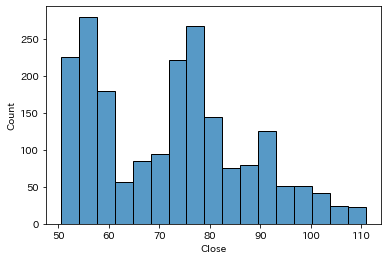

In [5]:
print('階差なし。右肩上がりのデータなのでヒストグラムいみないかも')
sns.histplot(df_train['Close'])
plt.show()


差が０以上の数 1027
差が0以下の数 980


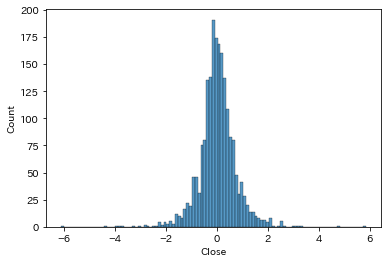

In [6]:
sns.histplot(df_train['Close'].diff())


print('差が０以上の数',df_train['Close'][df_train['Close'].diff() > 0 ].count())
print('差が0以下の数',df_train['Close'][df_train['Close'].diff() < 0 ].count())

１日前のdiffのヒストグラムをみると、中心がほぼ０で、均等に拡がってみえる。　が実際には株価の価格はあがっている  
差が０以上、０以下の数を比べてみると、０以上の値が多いので、徐々に増えている傾向が取れる。

階差をとってヒストグラム


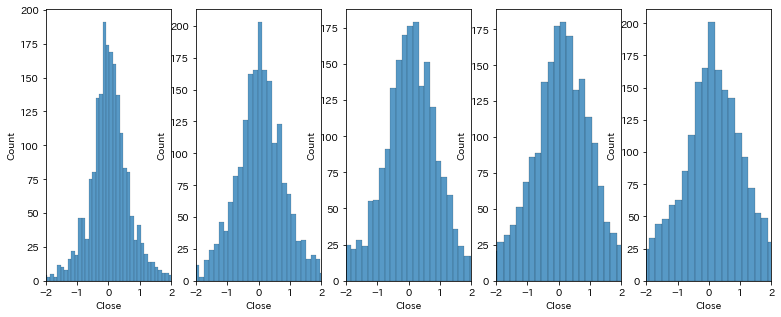

In [7]:
print('階差をとってヒストグラム')
fig,axes = plt.subplots(nrows = 1, ncols = 5,figsize = (13,5)) 


for i in range(1,6):
        sns.histplot(df_train['Close'].diff(i).dropna(),ax = axes[i-1])
        axes[i-1].set_xlim(-2,2)

plt.show()

１日前との差は微量だが、２日前、３日前・・となるとちょっとずつ差（裾）が大きくなる。  
が基本的に０（変動なし）が支配的

memo : 対数を取ると値ってどうなるんやっけ🤔  
→ 大きい値はあまり変化せず、小さい値は大きくなる。  
→ ヒストグラムで偏りがある場合、例えば、裾の右側が広がってる場合、大きい方はあまりかわらず、小さい方は大きくなるので正規分布っぽい形に変換される

<AxesSubplot:>

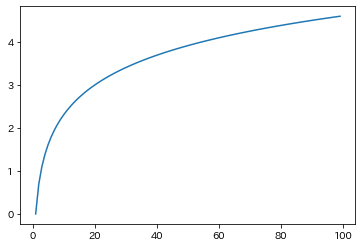

In [8]:
x = np.arange(1,100,1)
sns.lineplot(x = x, y = np.log(x))

<AxesSubplot:xlabel='Close', ylabel='Count'>

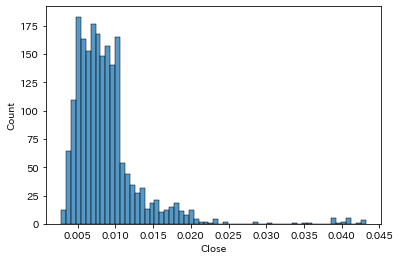

In [9]:

sns.histplot(np.log(df_train['Close']).diff().rolling(20).std())

## そのままデータの可視化

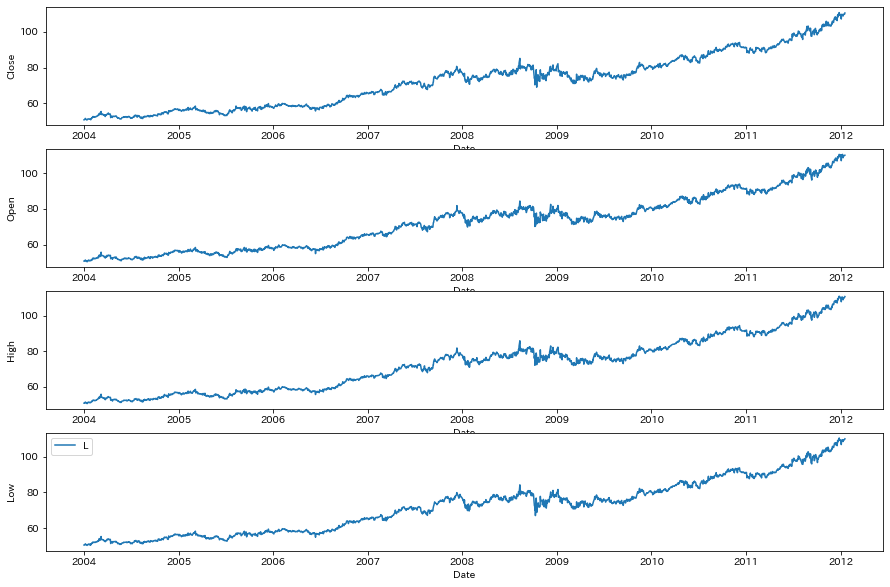

In [10]:
fig,axes = plt.subplots(4,1,figsize =(15,10))

columns_dic = {0:'Close',1:'Open',2:'High',3:'Low'}
for i in range(4):
    sns.lineplot(data = df_train, x = 'Date', y = columns_dic[i],ax = axes[i]) 
    plt.legend(columns_dic[i])
    

plt.show()

In [11]:
df_train

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


##　トレンドを見る。
### 月の平均データを集計　可視化

In [12]:
df_train['month_close_mean'] = df_train['Date'].dt.strftime('%Y-%m')
df_train.groupby(['month_close_mean'],as_index = False).mean()

,month_close_mean,Open,High,Low,Close,Up
0,2004-01,51.045000,51.212000,50.854000,51.053500,0.600000
1,2004-02,52.412105,52.687895,52.312632,52.551579,0.473684
2,2004-03,53.680870,53.990870,53.502609,53.720870,0.565217
3,2004-04,53.086667,53.329048,52.842857,53.043810,0.428571
4,2004-05,51.883000,52.091500,51.668000,51.870000,0.500000
5,2004-06,52.242857,52.416667,52.107619,52.249524,0.428571
6,2004-07,52.502381,52.724762,52.370476,52.563333,0.476190
7,2004-08,52.238182,52.440000,52.074091,52.258182,0.363636
8,2004-09,52.848095,53.057143,52.710952,52.897619,0.523810
9,2004-10,53.569048,53.785238,53.405238,53.631429,0.476190


<AxesSubplot:xlabel='month_close_mean', ylabel='Close'>

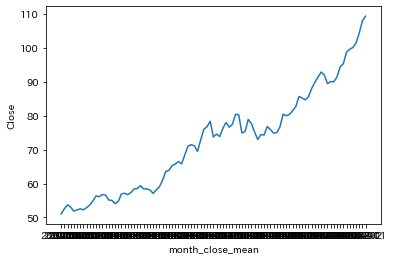

In [13]:
df_month_mean = df_train.groupby(['month_close_mean'],as_index = False).mean()
sns.lineplot(x = 'month_close_mean',y = 'Close',data = df_month_mean)

### 移動平均（トレンド）

In [14]:
df_train['mov_ave5'] = df_train['Close'].rolling(5).mean()
df_train['mov_ave10']= df_train['Close'].rolling(10).mean()
df_train['mov_ave20']= df_train['Close'].rolling(20).mean()

In [15]:
df_train.head(40)

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
5,2004-01-09,51.11,51.32,51.01,51.01,0,2004-01,51.148,NaN,NaN
6,2004-01-12,50.80,50.90,50.55,50.87,0,2004-01,51.164,NaN,NaN
7,2004-01-13,50.90,50.98,50.53,50.61,1,2004-01,51.056,NaN,NaN
8,2004-01-14,50.43,50.65,50.40,50.64,1,2004-01,50.882,NaN,NaN
9,2004-01-15,51.01,51.27,50.70,51.01,1,2004-01,50.828,50.959,NaN


No handles with labels found to put in legend.


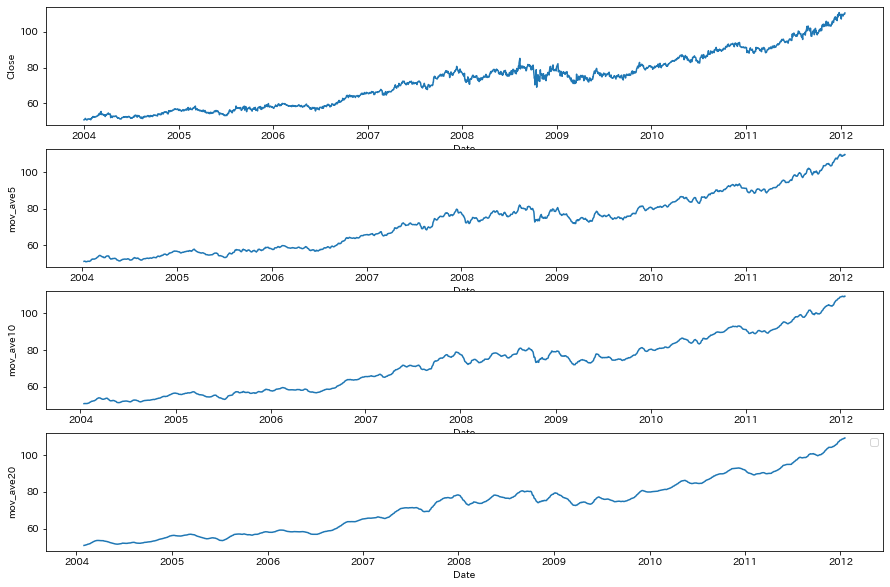

In [16]:
fig, axes = plt.subplots(nrows = 4,ncols = 1,figsize = (15,10))
sns.lineplot(data = df_train, x = 'Date', y = 'Close',ax=axes[0])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave5',ax=axes[1])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave10',ax=axes[2])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave20',ax=axes[3])

plt.legend()
plt.show()

右肩上がり。　季節性はなさそう？？

### 自己相関、偏相関
自己相関：時系列データで時間軸ごとの各データの相関（昨日の俺と今日の俺と明日の俺・・・・  
編自己相関：tとt-2の相関にはt-1の情報が入っている可能性があるのでそれをさっ引いた相関　（今日の俺と一昨日の俺を比較したいが、今日の俺は昨日の俺からできてる）

#### 月の自己相関

ある時点のデータと時間をずらしたデータの相関をプロット

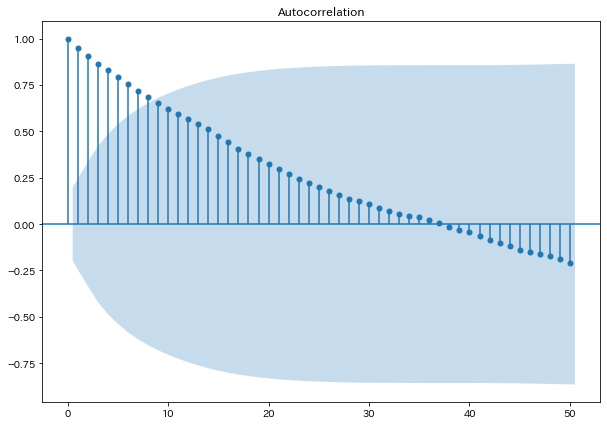

In [17]:
fig,axes = plt.subplots(1,1,figsize = (10,7))
sm.graphics.tsa.plot_acf(df_month_mean['Close'],lags = 50,ax = axes)
plt.show()

株価に周期性はなさそう

#### 月の偏自己相関を見てみる

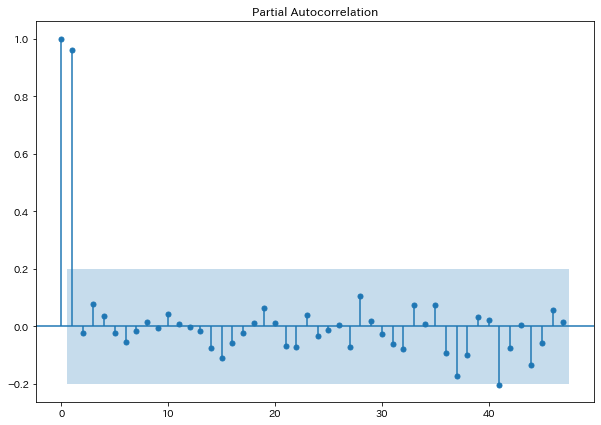

In [18]:
fig,axes = plt.subplots(1,1,figsize = (10,7))
sm.graphics.tsa.plot_pacf(df_month_mean['Close'],lags = 47,ax = axes)
plt.show()

#### ５日ごとの移動平均における偏自己相関
株価は上昇傾向なので自己相関は上と一緒  
偏自己相関だけみる

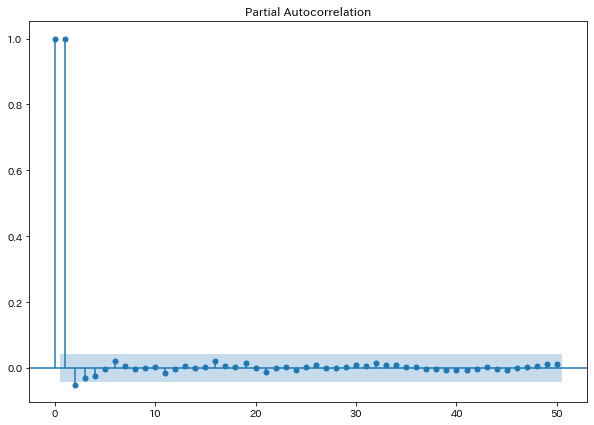

In [19]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave5'].dropna(),lags = 50,ax = axes)
plt.show()

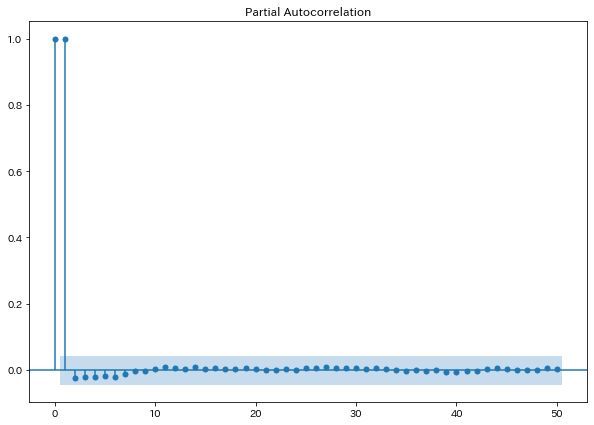

In [20]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave10'].dropna(),lags = 50,ax = axes)
plt.show()

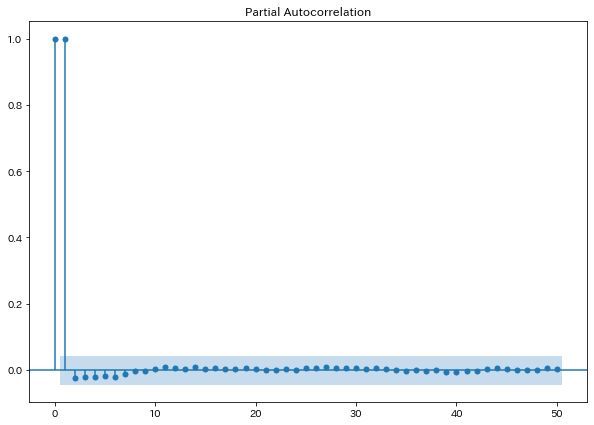

In [21]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave10'].dropna(),lags = 50,ax = axes)
plt.show()

月、５日移動平均、１０日移動平均、　いずれも前後では相関があるが、１個飛ばし以降のデータ（月なら翌々月）になると途端に相関はなくなる。

### トレンド　まとめ
1. 株価は全体的に上昇傾向があり、非定常である
2. 今月と翌月には相関があるが、翌々月には相関がない。  
   つまり、株価予測で重要なのは、一つ前の月の情報（先々月の情報はノイズになる）
1. 移動平均５日の場合でも同様。１個となりのデータは相関があるが、その次になると急に相関がなくなる。

## トレンド、季節性、残差に分解

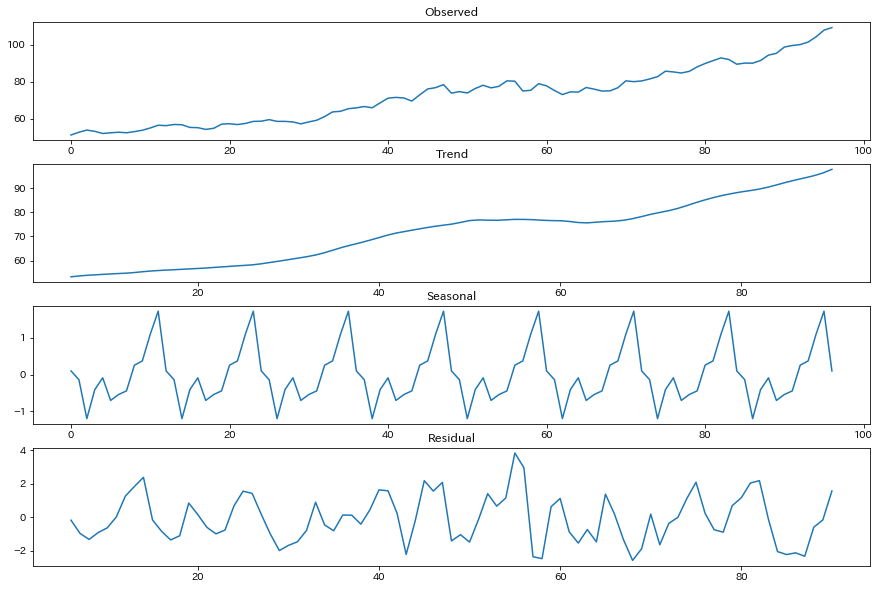

In [22]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_month_mean['Close'],period = 12)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(15,10))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

トレンドは上昇傾向  
季節性は実はある？が、縦軸の値が小さいのでほとんど効いてなさそう？　　

残差について：　　


## 定常性（トレンドを省く）
細かい説明は割愛しますが、トレンド成分が含まれているデータは「非定常」であるといい、分析がしにくい状態になっています。それに対して「定常」なデータは分析がしやすいのでデータを定常な状態にしたいです。通常、非定常なデータは差分をとることでトレンド成分を取り除き、定常にすることができます。また、データが定常であるかは「単位根検定」を行うことで調べることができます。
試しに、差分を取らずに原系列で単位根検定を行ってみます。今回はADF種類の単位根検定を用いました。

出力結果の値はP値を表しています。ADF検定ではデータが単位根過程であることが帰無仮説になっていているので、棄却することができればデータが単位根過程でない、つまり定常であると判断できます。

まず、データそのままで定常かどうか？の検定を行う

In [23]:
# トレンド項あり（１次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(df_train['Close'], regression="ct")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(df_train['Close'], regression="c")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(df_train['Close'], regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")

ct:
0.6598028157929887
---------------------------------------------------------------------------------------------------------------
c:
0.9962029554329336
---------------------------------------------------------------------------------------------------------------
nc:
0.9999775538994653
---------------------------------------------------------------------------------------------------------------


p値>0.05なので定常ではない。

次に階差をとってやってみる。diffすると欠損値がでるのでそれは落とす。

In [24]:
diff = df_train['Close'].diff()
diff = diff.dropna()

# トレンド項あり（１次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(diff, regression="ct")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(diff, regression="c")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(diff, regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")


ct:
1.169267666711396e-19
---------------------------------------------------------------------------------------------------------------
c:
1.0921080298402943e-22
---------------------------------------------------------------------------------------------------------------
nc:
0.0
---------------------------------------------------------------------------------------------------------------


p<0.05なので棄却　＝　非定常データにできた。

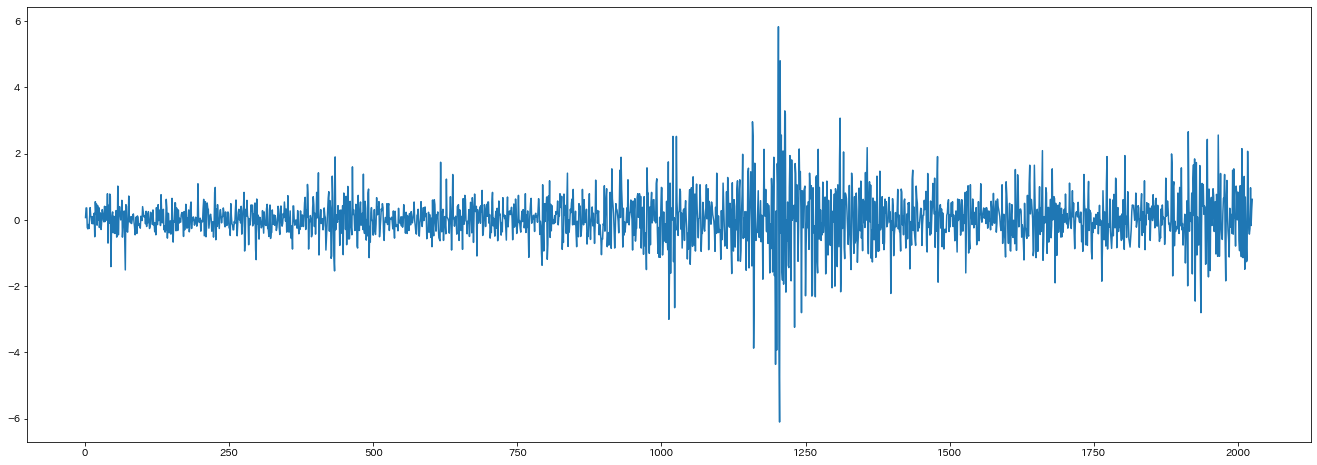

In [25]:
plt.figure(figsize = (23,8))
plt.plot(diff)

ARIMAは定常であること、もしくは階差のデータが定常であることを前提にしたモデルなので、  
上記のdiffした結果定常であるならばARIMAが使えるということ

statsmodelsのseasonal_decomposeを使うと、トレンド、周期、残差に分割できる

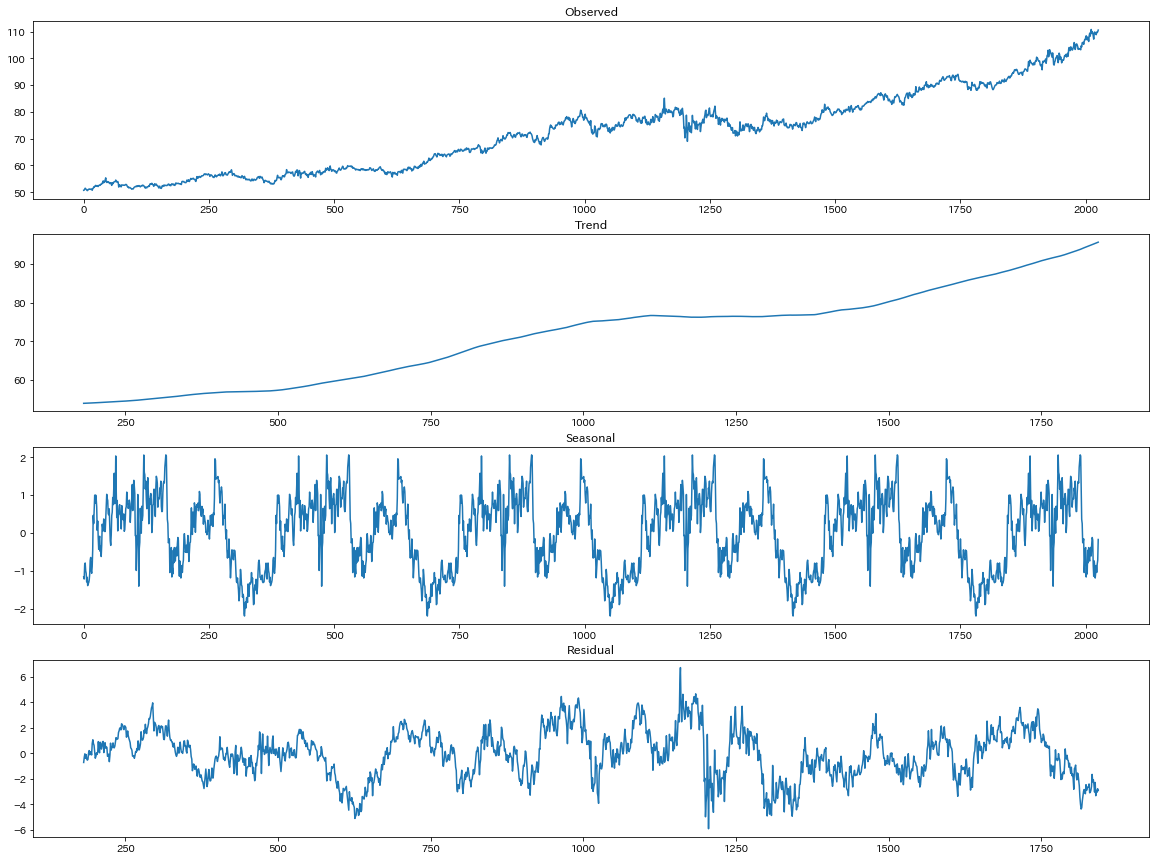

In [26]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_train['Close'],period = 365)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(20,15))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

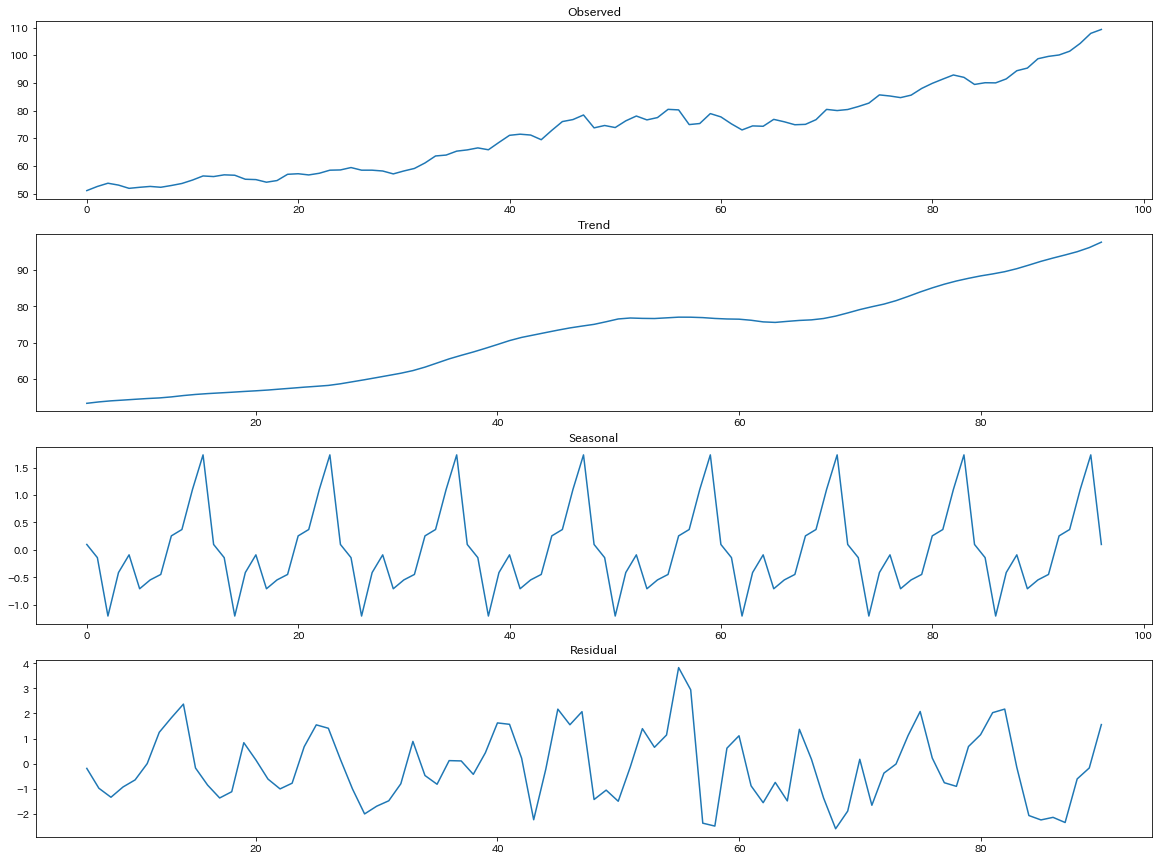

In [27]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_month_mean['Close'],period = 12)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(20,15))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

周期性（Seasonal）があるようにみえるが、縦軸の値が小さいからほとんど効いていないのだろうか・・？　　ここは色々と調べるといいかも  
ARIMAは周期性関係ない？のでARIMAでやってみる？
https://ichi.pro/suteppubaisuteppu-no-toki-keiretsu-bunseki-231932920417662

ARIMAモデルとは？？  
https://logics-of-blue.com/stock-price-forecast-by-arima/

>ARIMAモデルはAR・I・MAの3つに分かれます。
>
>AR:自己回帰モデル(ARモデル)  
>MA:移動平均モデル(MAモデル)  
>I:和分過程  
>
>自己回帰モデルと移動平均モデルは、各々単体でも予測に使うことのできる時系列モデルです。  
>2期前までのデータを使う自己回帰モデルを『AR(2)』と記します。p期前までのデータを使うならば『AR(p)』と表します。  
>同様に、q期前までのデータを使う移動平均モデルを『MA(q)』と表します。  
>両方をくっつけたものが『ARMA(p,q)』と呼ばれるモデルです。  
>pやqといった指定を「次数」とも呼びます。  
>次数が大きい方が、過去の長い期間を予測に使えますが、モデルとしては複雑になります。  
>
>自己回帰モデルと移動平均モデルの両方を組み合わせることによって、様々な時系列データに適用ができる柔軟なモデルを作ることができます。  
>また、過去のデータのうち、どれだけの期間を使うか（すなわちpやqをいくらにするか）を変えることによっても、挙動を変えることができます。  
>
>Iは何回和分かを表す部分です。  
>I(d)で、d階和分であることを表します。  
>
>和分とは、「和」ですので、足し合わせるという意味です。  
>例えば「１，２，３，４」の1階和分は「１，１＋２，１＋２＋３，１＋２＋３＋４」となります。  
>
>例えばARIMA(p,1,q)というモデルは「ARMA(p,q)モデルであらわされるデータの1階和分系列である」と解釈されます。  
>和分系列のままだと扱いが難しいですので、差分をとってから解析するのが普通です。  
>
>
>まとめます。  
>ARモデル・MAモデル共に、単体でも予測に使うことのできる時系列モデルです。  
>両者を合わせたARMAモデルは高い予測力を持ちます。  
>ARIMAモデルは、データの差分をとってからARMAモデルを推定したものです。  
>差分をとってデータを整形することで、ARMAモデルを正しく推定できるようにしています。  

#　memo 一旦、HoldoutでARIMAモデルやってみる

## ARIMAモデルのパラメータ設定
arimamモデルは3つのパラメータを持つ

1. AR(自己回帰)モデルにおける「回帰数」
2. 差分を取る「回数」。ここでの差分とは、時系列データにおいて隣り合うデータの差分
3. MA(移動平均)モデルにおける「平均を計算する際に考慮するデータ数」

1,3については算出してからパラメータに組み込む必要があるらしい  
２についてはエイヤッで１とする（という内容がネットにいっぱいある。。ようわからん）

参考：
https://logics-of-blue.com/python-time-series-analysis/

http://sweng.web.fc2.com/ja/program/python/time-series-forecast-arima-model.html

In [32]:
df_train

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,2012-01,109.330,109.123,108.7065
2022,2012-01-12,109.68,109.90,109.44,109.83,0,2012-01,109.444,109.174,108.8065
2023,2012-01-13,109.53,109.72,109.08,109.66,1,2012-01,109.404,109.139,108.9445
2024,2012-01-17,109.99,110.47,109.57,109.96,1,2012-01,109.486,109.169,109.0460


### memo 
order_select_icするとき　
* Closeデータでやると、（０、２）  
* mov_ave5でやると（４、２）
* month_mean_close['Close']でやると (4,2)

どれでやればいいんだろう。  
1個目のARが０はなんか微妙そうなきはする。

In [33]:
order_select_ic_featuring_dic = {0:'Close', 1: 'mov_ave5'}

resdiff_list = []
# Closeとmov_ave5でdiffして、order_select_icを算出
for i in range(2):
    diff = df_train[order_select_ic_featuring_dic[i]].diff()
    diff = diff.dropna()
    resdiff = sm.tsa.arma_order_select_ic(diff, ic = 'aic' ,trend = 'nc')# ic , trendの引数はよくわからん。　aicは計算？の方法　trend は条件、　trend = cでも知りたい情報かわらなかったからとりあえず適当のまま
    resdiff_list.append(resdiff)

# Closeとmov_ave5で　log diffして、order_select_icを算出

for i in range(2):
    diff = np.log(df_train[order_select_ic_featuring_dic[i]]).diff()
    diff = diff.dropna()
    resdiff = sm.tsa.arma_order_select_ic(diff, ic = 'aic' ,trend = 'nc')# ic , trendの引数はよくわからん。　aicは計算？の方法　trend は条件、　trend = cでも知りたい情報かわらなかったからとりあえず適当のまま
    resdiff_list.append(resdiff)

    

    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

In [34]:
#　4つの結果をしゅつりょく
for i in range(2):
    print(order_select_ic_featuring_dic[i],' diff ',resdiff_list[i].aic_min_order)

for i in range(2):
    print(order_select_ic_featuring_dic[i],' log diff ',resdiff_list[i+2].aic_min_order)

Close  diff  (0, 2)
mov_ave5  diff  (4, 2)
Close  log diff  (0, 2)
mov_ave5  log diff  (4, 2)


最後のaic_min_orderが　ARの回帰数、MAの平均を計算する際に考慮するデータ数　  
これをorderに入れる。

In [28]:
train_df,test_df = train_test_split(df_train,test_size = 0.2,shuffle = False)


In [29]:
train_end = '2010-05-28'
val_start = '2010-06-09'
val_end = '2012-01-12'
test_start = '2012-01-19'
test_end = '2019-12-23'

In [30]:
df_train

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,2012-01,109.330,109.123,108.7065
2022,2012-01-12,109.68,109.90,109.44,109.83,0,2012-01,109.444,109.174,108.8065
2023,2012-01-13,109.53,109.72,109.08,109.66,1,2012-01,109.404,109.139,108.9445
2024,2012-01-17,109.99,110.47,109.57,109.96,1,2012-01,109.486,109.169,109.0460


In [31]:
# 原系列
X_train = df_train[['Date','Close']].loc[df_train['Date'] <= train_end].dropna()
y_train = df_train['Up'].loc[df_train['Date'] <= train_end]

X_val = df_train[['Date','Close']].loc[(df_train['Date'] >= val_start) & (df_train['Date'] <= val_end)]
y_val = df_train['Up'].loc[(df_train['Date'] >= val_start) & (df_train['Date'] <= val_end)]

# 移動平均
X_train_mov_ave5 = df_train[['Date','mov_ave5']].loc[df_train['Date'] <= train_end].dropna()
y_train_mov_ave5 = df_train['Up'].loc[df_train['Date'] <= train_end]

X_val_mov_ave5 = df_train[['Date','mov_ave5']].loc[(df_train['Date'] >= val_start) & (df_train['Date'] <= val_end)]
y_val_mov_ave5 = df_train['Up'].loc[(df_train['Date'] >= val_start) & (df_train['Date'] <= val_end)]


In [32]:
X_train

,Date,Close
0,2004-01-02,50.72
1,2004-01-05,50.79
2,2004-01-06,51.15
3,2004-01-07,51.51
4,2004-01-08,51.28
...,...,...
1608,2010-05-24,84.77
1609,2010-05-25,84.30
1610,2010-05-26,83.77
1611,2010-05-27,83.76


## 原系列と移動平均、それぞれでモデル

### 原系列

In [104]:

model_arima = ARIMA(X_train['Close'],order = (4,1,2))

arima = model_arima.fit(dist = False)
arima.params

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

const            0.020410
ar.L1.D.Close   -0.458709
ar.L2.D.Close    0.081738
ar.L3.D.Close   -0.134403
ar.L4.D.Close   -0.011285
ma.L1.D.Close    0.325462
ma.L2.D.Close   -0.383453
dtype: float64

残差の自己相関を見てみる

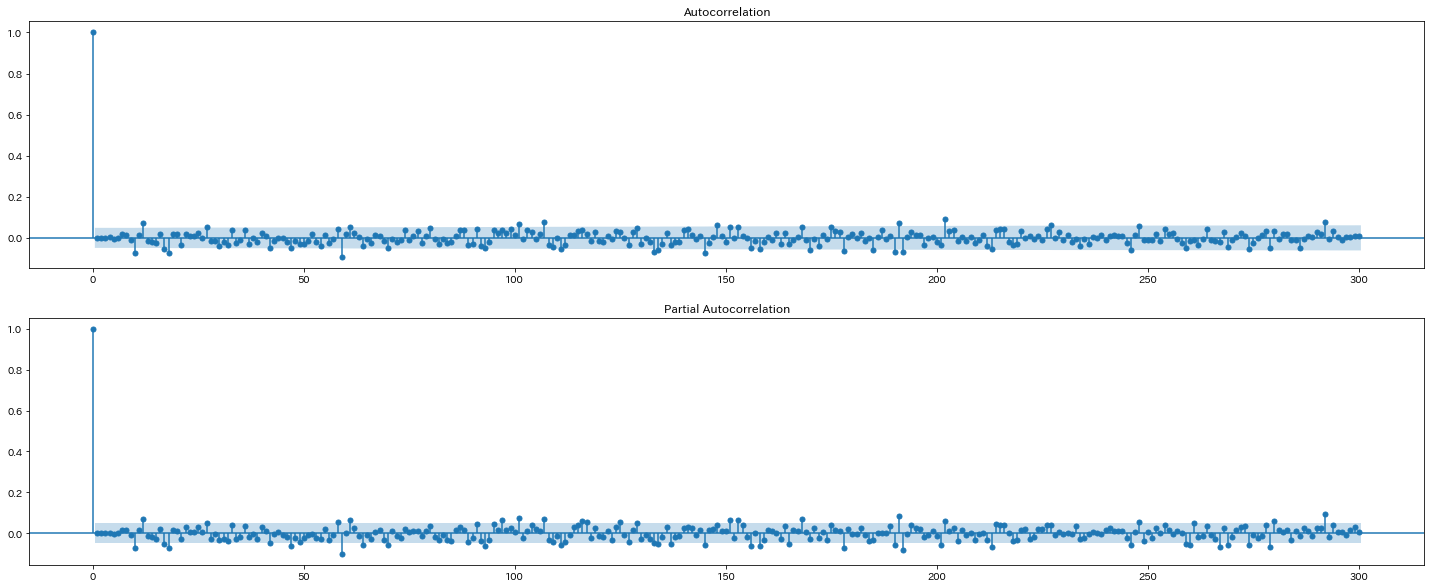

In [39]:
fig,axes = plt.subplots(nrows = 2, ncols = 1 , figsize = (25,10))

# 残差の自己相関
sm.graphics.tsa.plot_acf(x = arima.resid.values.squeeze(),lags = 300, ax = axes[0])
sm.graphics.tsa.plot_pacf(x = arima.resid.values.squeeze(),lags = 300, ax = axes[1])
plt.show()

残差に自己相関、偏自己相関はなさそう  

移動平均でもやってみる

### 移動平均

In [40]:
X_train_mov_ave5

,Date,mov_ave5
4,2004-01-08,51.090
5,2004-01-09,51.148
6,2004-01-12,51.164
7,2004-01-13,51.056
8,2004-01-14,50.882
...,...,...
1608,2010-05-24,84.866
1609,2010-05-25,84.524
1610,2010-05-26,84.260
1611,2010-05-27,84.182


In [41]:

model_arima_mov_ave5 = ARIMA(X_train_mov_ave5['mov_ave5'],order = (4,1,2))

arima_mov_ave5 = model_arima_mov_ave5.fit(dist = False)
arima_mov_ave5.params

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

const               0.020492
ar.L1.D.mov_ave5    1.244402
ar.L2.D.mov_ave5   -1.249497
ar.L3.D.mov_ave5    0.747624
ar.L4.D.mov_ave5   -0.309968
ma.L1.D.mov_ave5   -0.612118
ma.L2.D.mov_ave5    0.999979
dtype: float64

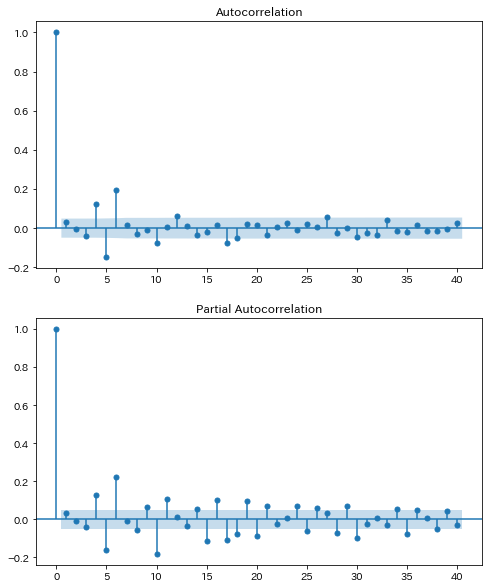

In [42]:
fig,axes = plt.subplots(nrows = 2, ncols = 1 , figsize = (8,10))

# 残差の自己相関
sm.graphics.tsa.plot_acf(x = arima_mov_ave5.resid.values.squeeze(),lags = 40, ax = axes[0])
sm.graphics.tsa.plot_pacf(x = arima_mov_ave5.resid.values.squeeze(),lags = 40, ax = axes[1])
plt.show()

移動平均だと、残差に周期的なデータがあるっぽいのか・・？　むずい・・・

In [43]:
df_train

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,2012-01,109.330,109.123,108.7065
2022,2012-01-12,109.68,109.90,109.44,109.83,0,2012-01,109.444,109.174,108.8065
2023,2012-01-13,109.53,109.72,109.08,109.66,1,2012-01,109.404,109.139,108.9445
2024,2012-01-17,109.99,110.47,109.57,109.96,1,2012-01,109.486,109.169,109.0460


In [44]:
X_val

,Date,Close
1619,2010-06-09,85.70
1620,2010-06-10,85.49
1621,2010-06-11,85.64
1622,2010-06-14,85.95
1623,2010-06-15,86.28
...,...,...
2018,2012-01-06,109.86
2019,2012-01-09,109.55
2020,2012-01-10,109.12
2021,2012-01-11,108.86


In [45]:
X_train.head(29)

,Date,Close
0,2004-01-02,50.72
1,2004-01-05,50.79
2,2004-01-06,51.15
3,2004-01-07,51.51
4,2004-01-08,51.28
5,2004-01-09,51.01
6,2004-01-12,50.87
7,2004-01-13,50.61
8,2004-01-14,50.64
9,2004-01-15,51.01


In [46]:
X_train['Date'].head(1),X_train['Date'].tail(1)

(0   2004-01-02
 Name: Date, dtype: datetime64[ns],
 1612   2010-05-28
 Name: Date, dtype: datetime64[ns])

In [48]:
arima_mov_ave5.predict(start = 1608,
                       end = 2022,
                       typ = 'levels'
                      )


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


1607    84.141094
1608    83.862144
1609    83.767240
1610    83.781043
1611    83.850053
          ...    
2017    92.230443
2018    92.250935
2019    92.271428
2020    92.291920
2021    92.312413
Length: 415, dtype: float64

In [49]:
val_start_index = df_train[(df_train['Date'] <= val_end) & (df_train['Date'] >= val_start)].index[0]
val_end_index = df_train[(df_train['Date'] <= val_end) & (df_train['Date'] >= val_start)].index[-1]
val_start_index,val_end_index

(1619, 2022)

In [50]:
train_end

'2010-05-28'

In [51]:
df_train[df_train['Date']<= train_end]

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1608,2010-05-24,84.91,85.43,84.46,84.77,0,2010-05,84.866,85.503,85.7825
1609,2010-05-25,83.32,84.30,83.02,84.30,0,2010-05,84.524,85.295,85.6775
1610,2010-05-26,85.24,85.37,83.77,83.77,0,2010-05,84.260,84.996,85.5605
1611,2010-05-27,83.14,83.76,82.84,83.76,0,2010-05,84.182,84.734,85.3900


## ARIMAの結果をプロット

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


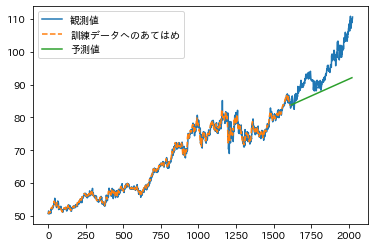

In [52]:

tup = arima_mov_ave5.forecast(steps=403)
plt.plot(df_train['Close'], label = '観測値')
plt.plot(arima_mov_ave5.predict(start = 2, end = 1612, typ='levels').values, '--', label="訓練データへのあてはめ")
plt.plot(range(1619,2022 ), tup[0], label = '予測値')
plt.legend()
plt.show()

めっちゃがばがばじゃね・・？ 適当に線ひいてるようにみえるんだけど・・
predict forecast　何か違いあるっぽいわ。

### モデルの作り直し
1. まず、trainデータで学習する
1. 学習したデータで1つ先の予測を出力する　（.forecast() )
1. 

In [53]:
history = [x for x in X_train['Close']]
predictions = list()

for t in range(len(X_val)):
    model = ARIMA(history, order = (4,1,2))
    model_fit = model.fit(disp = 0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_val['Close'].iloc[t]
    history.append(obs)
    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

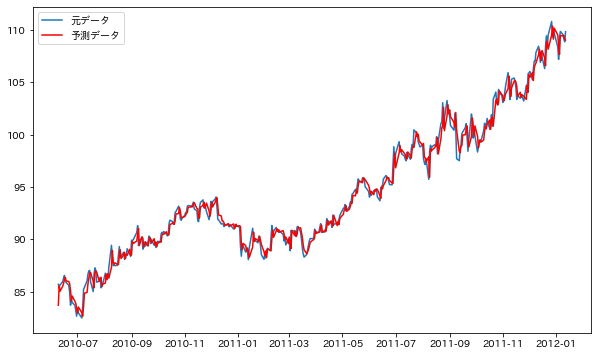

In [54]:
plt.figure(figsize = (10,6))
plt.plot(X_val['Date'],X_val['Close'],label = '元データ')
plt.plot(X_val['Date'],predictions, color = 'red',label = '予測データ')
plt.legend()
plt.show()

#### 移動平均でもやってみる

In [55]:
X_train['Close'].rolling(5).mean()

0          NaN
1          NaN
2          NaN
3          NaN
4       51.090
         ...  
1608    84.866
1609    84.524
1610    84.260
1611    84.182
1612    84.030
Name: Close, Length: 1613, dtype: float64

In [56]:
X_val['mov_ave5'] = X_val.rolling(5).mean()
X_val

,Date,Close,mov_ave5
1619,2010-06-09,85.70,NaN
1620,2010-06-10,85.49,NaN
1621,2010-06-11,85.64,NaN
1622,2010-06-14,85.95,NaN
1623,2010-06-15,86.28,85.812
...,...,...,...
2018,2012-01-06,109.86,108.874
2019,2012-01-09,109.55,108.852
2020,2012-01-10,109.12,108.996
2021,2012-01-11,108.86,109.330


In [60]:
# 移動平均をいれる
X_train['mov_ave5'] = X_train['Close'].rolling(5).mean()

# 最初の４個のデータがNaNになるのでCloseからコピペして補完
mov_ave5 = 5-1
for i in range(mov_ave5):
    X_train['mov_ave5'].iloc[i] = X_train['Close'].iloc[i]
X_train

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Close,mov_ave5
0,2004-01-02,50.72,50.720
1,2004-01-05,50.79,50.790
2,2004-01-06,51.15,51.150
3,2004-01-07,51.51,51.510
4,2004-01-08,51.28,51.090
...,...,...,...
1608,2010-05-24,84.77,84.866
1609,2010-05-25,84.30,84.524
1610,2010-05-26,83.77,84.260
1611,2010-05-27,83.76,84.182


1614

In [72]:
# 移動平均をいれる
X_val['mov_ave5'] = X_val['Close'].rolling(5).mean()

# 最初の４個のデータがNaNになるのでCloseからコピペして補完
mov_ave5 = 5-1
for i in range(mov_ave5):
    X_val['mov_ave5'].iloc[i] = X_val['Close'].iloc[i]
X_val

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Close,mov_ave5
1619,2010-06-09,85.70,85.700
1620,2010-06-10,85.49,85.490
1621,2010-06-11,85.64,85.640
1622,2010-06-14,85.95,85.950
1623,2010-06-15,86.28,85.812
...,...,...,...
2018,2012-01-06,109.86,108.874
2019,2012-01-09,109.55,108.852
2020,2012-01-10,109.12,108.996
2021,2012-01-11,108.86,109.330


In [73]:
history_mov_ave5 = [x for x in X_train['mov_ave5']]
predictions_mov_ave5 = list()


for t in range(len(X_val)):
    model_mov_ave5 = ARIMA(history_mov_ave5, order = (4,1,2))
    model_fit_mov_ave5 = model_mov_ave5.fit(disp = 0)
    output_mov_ave5 = model_fit_mov_ave5.forecast()
    yhat_mov_ave5 = output_mov_ave5[0]
    predictions_mov_ave5.append(yhat_mov_ave5)
    obs_mov_ave5 = X_val['mov_ave5'].iloc[t]
    history_mov_ave5.append(obs_mov_ave5)
    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

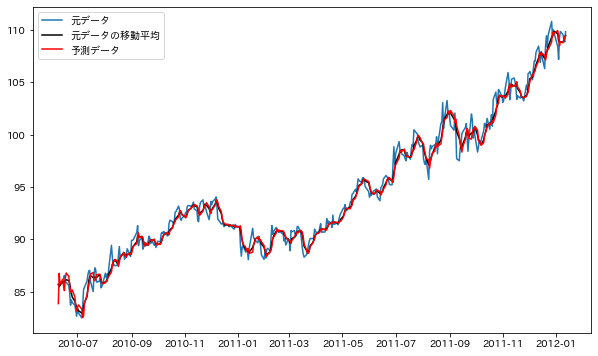

In [78]:
plt.figure(figsize = (10,6))
plt.plot(X_val['Date'],X_val['Close'],label = '元データ')
plt.plot(X_val['Date'],X_val['mov_ave5'],label = '元データの移動平均',color = 'black')
plt.plot(X_val['Date'],predictions_mov_ave5,label = '予測データ',color = 'red')
plt.legend()
plt.show()

## 作ったモデルにUpを追加していく

In [79]:
# 予測と真値を合体。
# predictions を　Seriesにして、index番号をX_valと同じにしてからconcatする

# predictionsの値１個１個がarrayになってるので全部をfloatになおす

pred = []
for i in range(len(predictions)):
    pred.append(float(predictions[i]))
    
predictions_df = pd.Series(pred,name = 'pred')
predictions_df.index = np.arange(X_val.index[0],X_val.index[-1]+1)
x_val_pred_df = pd.concat([X_val,predictions_df],axis = 1)
x_val_pred_df

,Date,Close,mov_ave5,pred
1619,2010-06-09,85.70,85.700,83.703981
1620,2010-06-10,85.49,85.490,85.540748
1621,2010-06-11,85.64,85.640,85.041122
1622,2010-06-14,85.95,85.950,85.511387
1623,2010-06-15,86.28,85.812,85.766147
...,...,...,...,...
2018,2012-01-06,109.86,108.874,109.473018
2019,2012-01-09,109.55,108.852,109.434005
2020,2012-01-10,109.12,108.996,109.487164
2021,2012-01-11,108.86,109.330,109.171602


次にx_val_pred_df のUpを実装する。　　
n番目のデータとn+1のデータを比べて　n+1 > n であれば　n番目のUpは１

#### memo apply 関数でやりたかったけどうまくできん。。あとで調査

In [80]:
# x_val_pred_df['Up'] = 0

# def compare_close_output_up(row):
#     tmp = row['pred'].diff()
#     tmp = tmp.fillna(-1)
    
#     if tmp > 0:
#         row['Up'] = 1
#     else: 
#         row['Up'] = 0
    
#     return row['Up']

In [81]:
x_val_pred_df = pd.concat([x_val_pred_df,y_val], axis = 1)
x_val_pred_df['pred_Up'] = 0

for i in range(len(x_val_pred_df)-1):

    if x_val_pred_df['pred'].iloc[i] < x_val_pred_df['pred'].iloc[i+1]:
        x_val_pred_df['pred_Up'].iloc[i] = 1
    else:
        x_val_pred_df['pred_Up'].iloc[i] = 0

x_val_pred_df

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Close,mov_ave5,pred,Up,pred_Up
1619,2010-06-09,85.70,85.700,83.703981,0,1
1620,2010-06-10,85.49,85.490,85.540748,1,0
1621,2010-06-11,85.64,85.640,85.041122,1,1
1622,2010-06-14,85.95,85.950,85.511387,1,1
1623,2010-06-15,86.28,85.812,85.766147,1,1
...,...,...,...,...,...,...
2018,2012-01-06,109.86,108.874,109.473018,0,0
2019,2012-01-09,109.55,108.852,109.434005,0,1
2020,2012-01-10,109.12,108.996,109.487164,0,0
2021,2012-01-11,108.86,109.330,109.171602,1,0


### 移動平均ver

In [82]:
# 予測と真値を合体。
# predictions を　Seriesにして、index番号をX_valと同じにしてからconcatする

# predictionsの値１個１個がarrayになってるので全部をfloatになおす

pred_mov_ave5 = []
for i in range(len(predictions_mov_ave5)):
    pred_mov_ave5.append(float(predictions_mov_ave5[i]))
    
predictions_df_mov_ave5 = pd.Series(pred_mov_ave5,name = 'pred')
predictions_df_mov_ave5.index = np.arange(X_val.index[0],X_val.index[-1]+1)
x_val_pred_df_mov_ave5 = pd.concat([X_val,predictions_df_mov_ave5],axis = 1)
x_val_pred_df_mov_ave5

,Date,Close,mov_ave5,pred
1619,2010-06-09,85.70,85.700,83.861478
1620,2010-06-10,85.49,85.490,86.757219
1621,2010-06-11,85.64,85.640,85.730034
1622,2010-06-14,85.95,85.950,86.168332
1623,2010-06-15,86.28,85.812,85.572429
...,...,...,...,...
2018,2012-01-06,109.86,108.874,108.863503
2019,2012-01-09,109.55,108.852,108.778548
2020,2012-01-10,109.12,108.996,109.058363
2021,2012-01-11,108.86,109.330,109.290463


In [83]:
x_val_pred_df_mov_ave5 = pd.concat([x_val_pred_df_mov_ave5,y_val], axis = 1)
x_val_pred_df_mov_ave5['pred_Up'] = 0

for i in range(len(x_val_pred_df_mov_ave5)-1):

    if x_val_pred_df_mov_ave5['pred'].iloc[i] < x_val_pred_df_mov_ave5['pred'].iloc[i+1]:
        x_val_pred_df_mov_ave5['pred_Up'].iloc[i] = 1
    else:
        x_val_pred_df_mov_ave5['pred_Up'].iloc[i] = 0

x_val_pred_df_mov_ave5

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Close,mov_ave5,pred,Up,pred_Up
1619,2010-06-09,85.70,85.700,83.861478,0,1
1620,2010-06-10,85.49,85.490,86.757219,1,0
1621,2010-06-11,85.64,85.640,85.730034,1,1
1622,2010-06-14,85.95,85.950,86.168332,1,0
1623,2010-06-15,86.28,85.812,85.572429,1,0
...,...,...,...,...,...,...
2018,2012-01-06,109.86,108.874,108.863503,0,0
2019,2012-01-09,109.55,108.852,108.778548,0,1
2020,2012-01-10,109.12,108.996,109.058363,0,1
2021,2012-01-11,108.86,109.330,109.290463,1,1


## モデルの評価
1. 原系列そのまま
2. mov_ave5のとき
3. mov_ave5 対数差分のとき

In [269]:
accuracy_score(x_val_pred_df['Up'],x_val_pred_df['pred_Up'])

0.5074257425742574

ちーん・・・・

In [84]:
accuracy_score(x_val_pred_df_mov_ave5['Up'],x_val_pred_df_mov_ave5['pred_Up'])

0.4876237623762376

ちんちーん・・・・


# testデータで予測値を出す。

In [87]:
df_test

,Date,Open,High,Low,Close,pred_flg
0,2012-01-19,110.79,110.82,109.96,110.39,0
1,2012-01-20,110.45,111.10,110.36,110.73,0
2,2012-01-23,110.95,111.10,109.65,110.36,0
3,2012-01-24,110.16,110.16,108.13,108.39,0
4,2012-01-25,106.25,107.11,105.97,106.89,0
...,...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68,0
1196,2019-12-18,183.86,184.01,182.38,183.10,0
1197,2019-12-19,183.83,185.17,183.66,185.08,0
1198,2019-12-20,186.29,186.64,184.81,185.19,0


In [92]:
len(df_test['Close'])

1200

In [93]:
history = [x for x in df_train['Close']]
predictions = list()

for t in range(len(df_test)):
    model = ARIMA(history, order = (4,1,2))
    model_fit = model.fit(disp = 0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test['Close'].iloc[t]
    history.append(obs)
    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

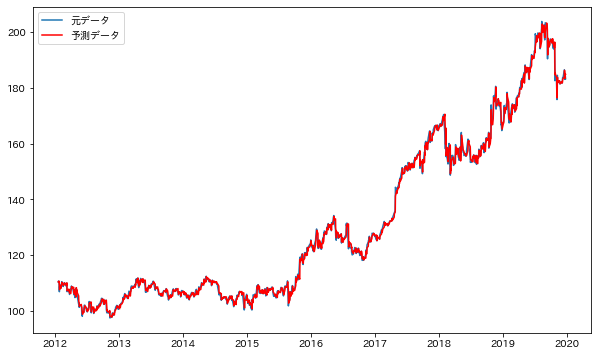

In [97]:
plt.figure(figsize = (10,6))
plt.plot(df_test['Date'],df_test['Close'],label = '元データ')
plt.plot(df_test['Date'],predictions,label = '予測データ',color = 'red')
plt.legend()
plt.show()

In [107]:
pred = []
for i in range(len(predictions)):
    pred.append(float(predictions[i]))
    
predictions_df = pd.Series(pred,name = 'pred')
predictions_df.index = np.arange(df_test.index[0],df_test.index[-1]+1)
test_pred_df = pd.concat([df_test,predictions_df],axis = 1)
test_pred_df

,Date,Open,High,Low,Close,pred_flg,pred
0,2012-01-19,110.79,110.82,109.96,110.39,0,110.435893
1,2012-01-20,110.45,111.10,110.36,110.73,0,110.264435
2,2012-01-23,110.95,111.10,109.65,110.36,0,110.705479
3,2012-01-24,110.16,110.16,108.13,108.39,0,110.314176
4,2012-01-25,106.25,107.11,105.97,106.89,0,108.723347
...,...,...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68,0,186.352443
1196,2019-12-18,183.86,184.01,182.38,183.10,0,184.276529
1197,2019-12-19,183.83,185.17,183.66,185.08,0,183.448196
1198,2019-12-20,186.29,186.64,184.81,185.19,0,185.193211


In [108]:
test_pred_df['pred_Up'] = 0

for i in range(len(test_pred_df)-1):

    if test_pred_df['pred'].iloc[i] < test_pred_df['pred'].iloc[i+1]:
        test_pred_df['pred_Up'].iloc[i] = 1
    else:
        test_pred_df['pred_Up'].iloc[i] = 0

test_pred_df

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Open,High,Low,Close,pred_flg,pred,pred_Up
0,2012-01-19,110.79,110.82,109.96,110.39,0,110.435893,0
1,2012-01-20,110.45,111.10,110.36,110.73,0,110.264435,1
2,2012-01-23,110.95,111.10,109.65,110.36,0,110.705479,0
3,2012-01-24,110.16,110.16,108.13,108.39,0,110.314176,0
4,2012-01-25,106.25,107.11,105.97,106.89,0,108.723347,0
...,...,...,...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68,0,186.352443,0
1196,2019-12-18,183.86,184.01,182.38,183.10,0,184.276529,0
1197,2019-12-19,183.83,185.17,183.66,185.08,0,183.448196,1
1198,2019-12-20,186.29,186.64,184.81,185.19,0,185.193211,0


In [109]:
test_pred_df['pred_flg']

0       0
1       0
2       0
3       0
4       0
       ..
1195    0
1196    0
1197    0
1198    0
1199    1
Name: pred_flg, Length: 1200, dtype: int64

In [112]:
test_pred_df = test_pred_df.loc[test_pred_df['pred_flg']==1][['Date','pred_Up']]

KeyError: 'pred_flg'

In [116]:
test_pred_df.to_csv('submit_0702.csv',index = False)

# memo 
パラメータの組み合わせをやってみる

In [35]:
range(1,5)

range(1, 5)

In [34]:
for d in range(1,5):
    print(d)
    if d == range(1,5)

1
2
3
4


In [47]:
(3 != 1) & (2 != 1)

True

In [48]:
d = 1
q = 0
p = 0

if (d != 0) & (q != 1) & (p != 1):
    print('True')

True


In [ ]:
history = [x for x in X_train['Close']]
predictions = list()

for p in range(6):
    for q in range(6):
        for d in range(1,6):
            # 一番最初のループのときだけモデルでの結果がないので、ここを通り抜ける
            if (d != 0) & (q != 1) & (p != 1):
                # 予測と真値を合体。
                # predictions を　Seriesにして、index番号をX_valと同じにしてからconcatする
                # predictionsの値１個１個がarrayになってるので全部をfloatになおす
                
                pred = []
                for i in range(len(predictions)):
                    pred.append(float(predictions[i]))
                predictions_df = pd.Series(pred,name = 'pred')
                predictions_df.index = np.arange(X_val.index[0],X_val.index[-1]+1)
                x_val_pred_df = pd.concat([X_val,predictions_df],axis = 1)
                accuracy_score(x_val_pred_df['Up'],x_val_pred_df['pred_Up'])
                
                x_val_pred_df = pd.concat([x_val_pred_df,y_val], axis = 1)
                x_val_pred_df['pred_Up'] = 0

                for i in range(len(x_val_pred_df)-1):

                    if x_val_pred_df['pred'].iloc[i] < x_val_pred_df['pred'].iloc[i+1]:
                        x_val_pred_df['pred_Up'].iloc[i] = 1
                    else:
                        x_val_pred_df['pred_Up'].iloc[i] = 0
                accuracy_score(x_val_pred_df['Up'],x_val_pred_df['pred_Up'])
                
                
            print('accuracy is : ', a)
            print('_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/_/')
            print('p,q,r : ',p,q,r)
            for t in range(len(X_val)):
                model = ARIMA(history, order = (p,d,q))
                model_fit = model.fit(disp = 0)
                output = model_fit.forecast()
                yhat = output[0]
                predictions.append(yhat)
                obs = X_val['Close'].iloc[t]
                history.append(obs)
                

In [ ]:
accuracy_score(x_val_pred_df['Up'],x_val_pred_df['pred_Up'])